In [2]:
import numpy as np
import xarray as xr
import netCDF4 
import MITgcmutils as mit
import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmocean

import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter

from geopy.distance import great_circle
from scipy.spatial import cKDTree
from numba import njit



In [3]:
@njit(cache=True)
def lonlat_to_xyz(lon, lat):
    """経度・緯度を3次元座標に変換"""
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)  # 度からラジアンに変換
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

# @njit(cache=True)
def calculate_top_l_indices_and_norms_ckdtree(XCYC1, XCYC2, l):
    """
    XCYC2 の各点に対して、XCYC1 からノルムが小さい順に l 点のインデックスとノルムを計算（cKDTree を使用）。
    """
    # XCYC1 を3次元座標に変換して平坦化
    m, n = XCYC1.shape[:2]
    flattened_XCYC1 = XCYC1.reshape(-1, 2)
    points_xyz = np.array([lonlat_to_xyz(lon, lat) for lon, lat in flattened_XCYC1])

    # cKDTree を構築
    tree = cKDTree(points_xyz)

    # 結果を格納する配列を初期化
    top_l_indices = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l, 2), dtype=int)
    top_l_norms = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l))  # ノルムを格納

    # 各点を探索
    for i in range(XCYC2.shape[0]):
        for j in range(XCYC2.shape[1]):
            lon_query, lat_query = XCYC2[i, j, :]  # 経度、緯度を取得
            x_query, y_query, z_query = lonlat_to_xyz(lon_query, lat_query)

            # 最近傍探索
            distances, indices = tree.query([x_query, y_query, z_query], k=l)

            # インデックスを 2D の形状に変換
            if l == 1:  # l=1 の場合、スカラーが返るので処理を分岐
                indices = [indices]  # リスト化
                distances = [distances]  # リスト化

            unraveled_indices = np.unravel_index(indices, (m, n))

            for k in range(l):
                # インデックスを格納
                top_l_indices[i, j, k, :] = [unraveled_indices[0][k], unraveled_indices[1][k]]

            # ノルムを計算（geopy を使用）
            for k in range(l):
                lon1, lat1 = XCYC1[top_l_indices[i, j, k, 0], top_l_indices[i, j, k, 1]]
                lon2, lat2 = XCYC2[i, j, 0], XCYC2[i, j, 1]

                top_l_norms[i, j, k] = great_circle((lat1, lon1), (lat2, lon2)).kilometers

    return top_l_indices, top_l_norms


@njit(cache=True)
def regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2.):
    """
    XCYC2 の各点に対応する data の値を IDW（逆距離加重法）で内挿。

    Args:
        XCYC1 (ndarray): 元の座標データ (形状: [m, n, 2])
        XCYC2 (ndarray): 対応する座標データ (形状: [p, q, 2])
        top_l_indices (ndarray): 最近傍 l 点のインデックス (形状: [p, q, l, 2])
        top_l_norms (ndarray): 最近傍 l 点のノルム (形状: [p, q, l])
        data (ndarray): 元データ (例: SSS) (形状: [m, n])
        p (float): 重み計算のパラメータ（デフォルトは 1.）

    Returns:
        regridded_data (ndarray): 変換後の座標 XCYC2 上に内挿されたデータ (形状: [p, q])
    """
    # 結果を格納する配列を初期化
    regridded_data = np.empty((XCYC2.shape[0], XCYC2.shape[1]))

    l = top_l_indices.shape[2]  # 最近傍点の数
    
    # データ内挿処理
    for i in range(XCYC2.shape[0]):  # XCYC2 の 1 軸目
        for j in range(XCYC2.shape[1]):  # XCYC2 の 2 軸目
            
            # 条件: 最近傍のノルムが閾値未満の場合、その値を直接代入
            # if top_l_norms[i, j, 0] < 1.e-10: #when unit is deg, worked well(to some extent).
            if top_l_norms[i, j, 0] < 1.e-4: #when unit is kilomerter, worked well.


                idx_x, idx_y = top_l_indices[i, j, 0]
                regridded_data[i, j] = data[idx_x, idx_y]
                continue
            
            # 各点の重み付けと加算
            weighted_sum = 0.0
            weight_total = 0.0
            for k in range(l):
                weight = top_l_norms[i, j, k] ** -p
                idx_x, idx_y = top_l_indices[i, j, k]
                weighted_sum += data[idx_x, idx_y] * weight
                weight_total += weight
            
            # 正規化（重みの合計で割る）
            regridded_data[i, j] = weighted_sum / (weight_total + 1.e-15) #when unit is deg, worked well.


    return regridded_data


In [4]:
fileloc_TauX = '/home/tsuribeh/Forcing_data/J-OFURO3/dias/data/J-OFURO3_V1_2/MONTHLY/HR/TAUX/'
fileloc_TauY = '/home/tsuribeh/Forcing_data/J-OFURO3/dias/data/J-OFURO3_V1_2/MONTHLY/HR/TAUY/'

fileloc_Clim = '/home/tsuribeh/Forcing_data/J-OFURO3/dias/data/J-OFURO3_V1_2/CLIMATOLOGY/'


In [5]:
# すべてのnetCDFファイルを読み込む
file_list_TauX = sorted(glob.glob(fileloc_TauX+"J-OFURO3_TAUX_V1.2_MONTHLY_HR_*.nc"))
file_list_TauY = sorted(glob.glob(fileloc_TauY+"J-OFURO3_TAUY_V1.2_MONTHLY_HR_*.nc"))


# すべての年をまとめて読み込み
# ds_all_years = xr.open_mfdataset(file_list_TauX, combine='by_coords')
ds_all_years = xr.open_mfdataset(file_list_TauY, combine='by_coords')


# time変数がdatetime64であることを確認し、なければ変換
if not np.issubdtype(ds_all_years.time.dtype, np.datetime64):
    ds_all_years['time'] = xr.cftime_range(start='1900-01', periods=ds_all_years.time.size, freq='MS')

# 月ごとの平均（climatology）を計算
climatology = ds_all_years.groupby('time.month').mean('time')

# 必要なら保存
# climatology.to_netcdf(fileloc_to_write+"TauX_J-OFULO3_1991_2011_climatology.nc")
# climatology.to_netcdf(fileloc_to_write+"TauY_J-OFULO3_1991_2011_climatology.nc")


In [6]:
TauX_climatology = xr.open_dataset(fileloc_Clim+"TauX_J-OFURO3_1991_2011_climatology.nc")

TauY_climatology = xr.open_dataset(fileloc_Clim+"TauY_J-OFURO3_1991_2011_climatology.nc")


In [7]:
TauY_np = TauY_climatology['TAUY'].values  # shape: (12, 720, 1440)
TauX_np = TauX_climatology['TAUX'].values  # shape: (12, 720, 1440)



In [8]:
lat_np = TauY_climatology['latitude'].values  # shape: (720,)
lon_np = TauY_climatology['longitude'].values  # shape: (1440,)


In [9]:
TauX_yrmean = np.mean(TauX_np, axis=0) #年平均
TauY_yrmean = np.mean(TauY_np, axis=0) #年平均


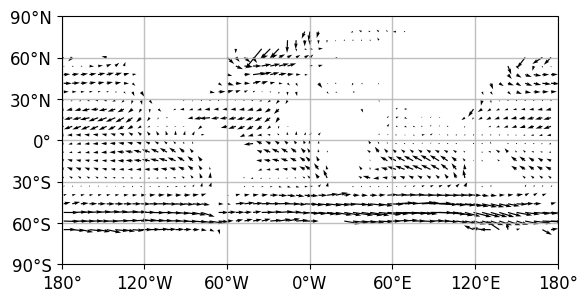

In [10]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Umin= min(np.nanmin(Uocn_regrid),-np.nanmax(Uocn_regrid))
d=0

plot_pace = 25
qv = ax.quiver(lon_np[::plot_pace],lat_np[::plot_pace], TauX_yrmean[::plot_pace,::plot_pace],TauY_yrmean[::plot_pace,::plot_pace])
                   

# カラーバーを追加
# cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
# cb.set_label("Velociity [m/s]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

In [11]:
TauX_znyrmean = np.empty_like(TauX_yrmean)
for i in range(len(lon_np)):
    TauX_znyrmean[:,i] = np.nanmean(TauX_yrmean, axis=1)
    

/tmp/ipykernel_696232/1495014142.py:3: RuntimeWarning: Mean of empty slice
  TauX_znyrmean[:,i] = np.nanmean(TauX_yrmean, axis=1)


In [12]:
TauY_znyrmean = np.empty_like(TauY_yrmean)
for i in range(len(lon_np)):
    TauY_znyrmean[:,i] = np.nanmean(TauY_yrmean, axis=1)
    

/tmp/ipykernel_696232/2754889207.py:3: RuntimeWarning: Mean of empty slice
  TauY_znyrmean[:,i] = np.nanmean(TauY_yrmean, axis=1)


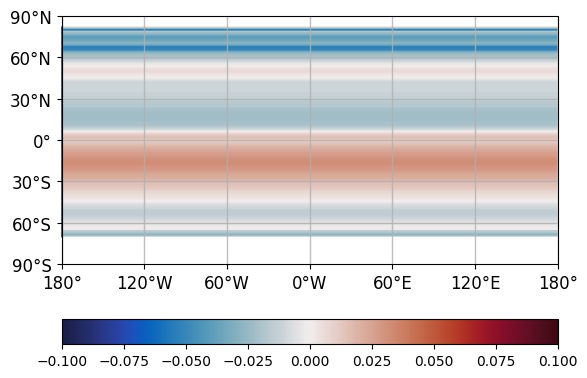

In [13]:
data = TauY_znyrmean

dmax= max(np.max(data), -np.min(data))

fig=plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon_np,lat_np, data, vmax= dmax, vmin =-dmax
   ,cmap=  cmocean.cm.balance
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
# cb.set_label("Temperature [${}^\circ\\mathrm{C}$]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

In [14]:
#Directory for cs grid
fileloc_csgrid = '/home/tsuribeh/MITgcm/cases_tsuribeh_bachelor/cpl_aim+ocn_cs32/rank_1/'
# CSグリッドデータの読み込み
XC = mit.mds.rdmds(fileloc_csgrid+'XC') #longitude at cell center
YC = mit.mds.rdmds(fileloc_csgrid+'YC') #latitude at cell center
XG = mit.mds.rdmds(fileloc_csgrid+'XG')
YG = mit.mds.rdmds(fileloc_csgrid+'YG')
# RC = mit.mds.rdmds(fileloc_csgrid+'RC')  # セル中心の深さ can be changed
# RF = mit.mds.rdmds(fileloc_csgrid+'RF')  # セル境界の深さ can be changed

# fileloc_latlondata ='/home/tsuribeh/MITgcm/cases_tsuribeh/global_ocean.cs32x15_originalbathy/input/latlon_inputdata/'

XCYC = np.stack([XC,YC],axis=2)
XGYG = np.stack([XG,YG],axis=2)

lon,lat = np.meshgrid(lon_np,lat_np)
lonlat = np.stack([lon,lat],axis=2)

#compute indice and norm for regridding
top_indices_XCYC_to_lonlat, top_norms_XCYC_to_lonlat = calculate_top_l_indices_and_norms_ckdtree(XCYC, lonlat, l=4)
top_indices_lonlat_to_XCYC, top_norms_lonlat_to_XCYC = calculate_top_l_indices_and_norms_ckdtree(lonlat, XCYC, l=4)


In [15]:
TauX_regrid= regrid_data(lonlat, XCYC, top_indices_lonlat_to_XCYC,top_norms_XCYC_to_lonlat,TauX_znyrmean.astype('<f8'),p=2.) 
TauY_regrid= regrid_data(lonlat, XCYC, top_indices_lonlat_to_XCYC,top_norms_XCYC_to_lonlat,TauY_znyrmean.astype('<f8'),p=2.) 


In [16]:
TauX_regrid[np.isnan(TauX_regrid)] =0.
TauY_regrid[np.isnan(TauY_regrid)] =0.


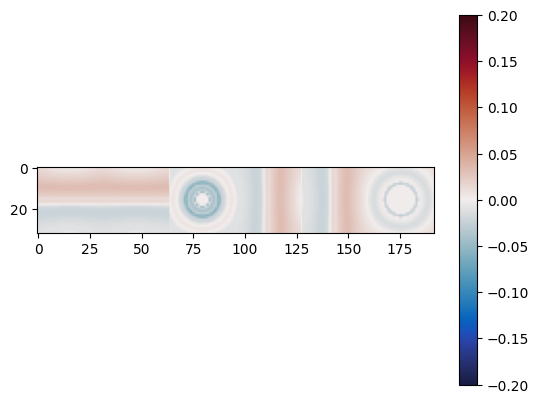

In [18]:
plt.imshow(TauY_regrid, cmap=cmocean.cm.balance,vmax=0.2, vmin=-0.2)
plt.colorbar()

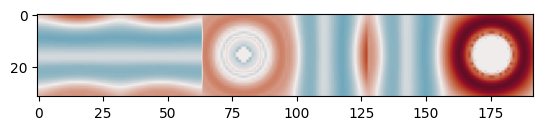

In [29]:
plt.imshow(TauX_regrid, cmap=cmocean.cm.balance,vmax=0.2, vmin=-0.2)

In [24]:
fileloc_to_write = '/home/tsuribeh/MITgcm/cases_tsuribeh_master/St50Ma_OCN/input/'

In [25]:
TauX_to_write = np.empty((12,32,192))
TauY_to_write = np.empty((12,32,192))
TauX_to_write[:] = TauX_regrid
TauY_to_write[:] = TauY_regrid 


In [26]:
mit.writebin(fileloc_to_write+'J-OFURO_TauX_steady.CS32.bin',TauX_to_write, dataprec='float64' )
mit.writebin(fileloc_to_write+'J-OFURO_TauY_steady.CS32.bin',TauY_to_write, dataprec='float64' )


In [27]:
np.unique(np.isnan(TauX_to_write))

array([False])